<h1>Segmentazione</h1>

<h3>Introduzione e Immagini usate</h3>


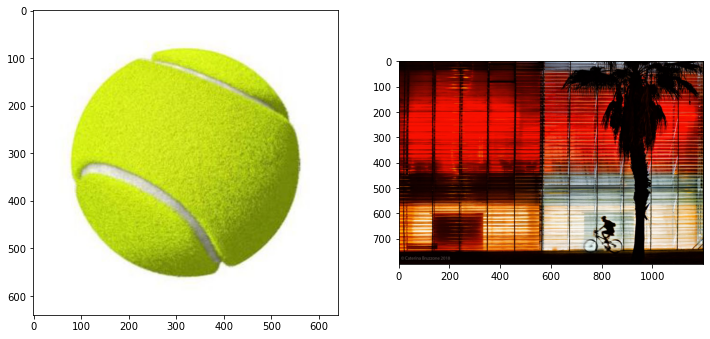

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2gray

ballImg = plt.imread('./tennis_ball.jpg')
moveImg = plt.imread('./movement.jpg')
fig, axes = plt.subplots(1, 2, figsize=(12, 12))
ax = axes.ravel()
_ = ax[0].imshow(ballImg)
_ = ax[1].imshow(moveImg)

<h3>Active contour</h3>

<p>Lorem ipsum </p>


In [6]:
# TODO: Whole active contour function



<h3>Edge Detection</h3>

Proviamo ora a implementare un altro metodo per la segmentazione delle immagini
basato sulla rilevazione dei bordi attraverso filtri convoluzionali, usando applicazioni
dei filtri di Sobel, Prewitt e Laplace e confrontando i risultati ottenuti

In [7]:
def apply_kernel(kernel, img, threshold = 0):
    rows = len(img)
    col = len(img[0])
    res = np.zeros((rows-1, col-1))

    for r in range(0, rows - 2):
        for c in range(0, col - 2):
            matrix = img[r:r+3, c:c+3]
            s1 = np.sum(np.sum(kernel*matrix))
            s2 = np.sum(np.sum(kernel.T*matrix))
            res[r+1, c+1] = np.sqrt(s1**2+s2**2)
            if res[r+1, c+1] <= threshold:
                res[r+1, c+1] = 0
    return res

In [8]:
gray_ball = rgb2gray(ballImg)
laplace_kernel = np.array([np.array([0, 1, 0]), np.array([1, -4, 1]), np.array([0, 1, 0])])
sobel_kernel = np.array([np.array([1, 0, -1]), np.array([2, 0, -2]), np.array([1, 0, -1])])
prewitt_kernel = np.array([np.array([-1, 0, 1]), np.array([-1, 0, 1]), np.array([-1, 0, 1])])
tennis_ball = [{"name": "Originale", "img": gray_ball},
               {"name": "Sobel", "img": apply_kernel(sobel_kernel, gray_ball, .25)},
               {"name": "Prewitt", "img": apply_kernel(prewitt_kernel, gray_ball, .25)},
               {"name": "Laplace", "img": apply_kernel(laplace_kernel, gray_ball)}]

Visualizziamo i risultati dell'esecuzione sulla pallina da tennis

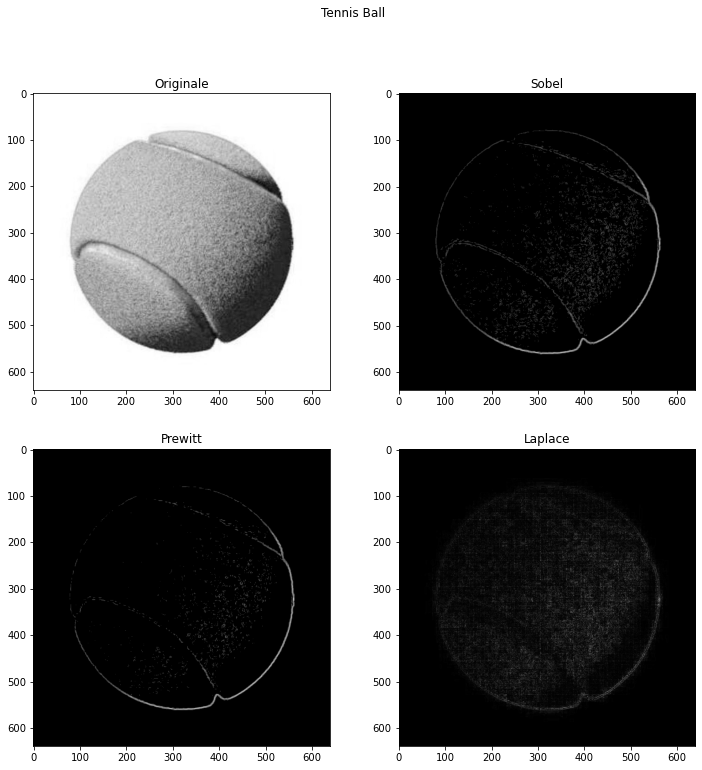

In [9]:
tbcp = tennis_ball.copy()
tbcp.reverse()
f, axes = plt.subplots(2, 2, figsize=(12, 12))
f.suptitle("Tennis Ball")
for ax in axes:
    for elem in ax:
        n = tbcp.pop()
        elem.imshow(n['img'], cmap=plt.cm.gray)
        elem.set_title(n['name'])

Proviamo ora ad applicare i filtri in uno scenario più complesso e visualizzarne i risultati


In [10]:
moveImgBn = rgb2gray(moveImg)
moveImgBn = [{"name": "Originale", "img": moveImgBn},
               {"name": "Sobel", "img": apply_kernel(sobel_kernel, moveImgBn, .25)},
               {"name": "Prewitt", "img": apply_kernel(prewitt_kernel, moveImgBn, .25)},
               {"name": "Laplace", "img": apply_kernel(laplace_kernel, moveImgBn)}]

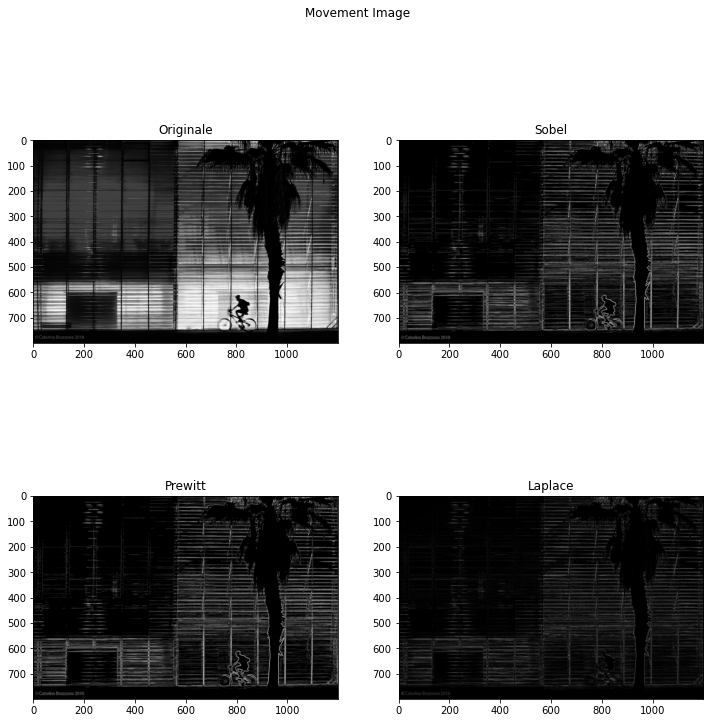

In [11]:
mvimg = moveImgBn.copy()
mvimg.reverse()
f , axes = plt.subplots(2, 2, figsize=(12, 12))
f.suptitle("Movement Image")
for ax in axes:
    for elem in ax:
        n = mvimg.pop()
        elem.imshow(n['img'], cmap=plt.cm.gray)
        elem.set_title(n['name'])